# Titanic 

## Project Description

### Overview
---
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Description of  features within dataset 
---
| Variable | Definition | Key |
|---|---|---|
|survival | Survival | 0 = No, 1 = Yes
|pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd
|sex	| Sex |
|Age	| Age in years |	
|sibsp	| # of siblings / spouses aboard the Titanic |	
|parch	| # of parents / children aboard the Titanic |	
|ticket	| Ticket number	|
|fare	| Passenger fare |	
|cabin	| Cabin number |	
|embarked |	Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

### Variable Notes
---
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


## Data exploration

In [2]:
## Import dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sys
import os
os.getcwd()
sys.path.insert(0, '..')
from src.correlation_eval import theils_u

In [3]:
## load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

### General Information

#### Observations:
- the training set contains 891 samples,while the testing set contains  418 samples
- 

In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Missing values

(add insights)

In [9]:
train_count_nan=train_data.isna().sum(axis=0)
test_count_nan=test_data.isna().sum(axis=0)
train_count_nan[train_count_nan>0]


Age         177
Cabin       687
Embarked      2
dtype: int64

Missing values in the test set: Age, Fare, Cabin

In [10]:
test_count_nan[test_count_nan>0]

Age       86
Fare       1
Cabin    327
dtype: int64

#### There is no significant difference for the feature space in train set  and test set

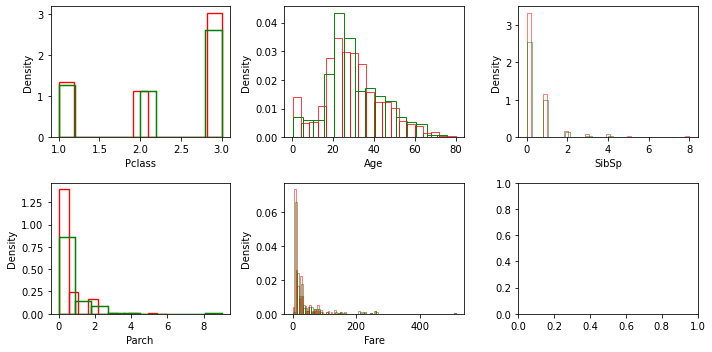

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(10,5))
num_cols = ['Pclass', 'Age', 'SibSp','Parch', 'Fare']
for idx, col in enumerate(num_cols):
    sns.histplot(data=train_data, x=col, color='r', alpha=0.3, stat='density', fill=False,
                 ax=ax[idx//3, idx%3],  )
    sns.histplot(data=test_data, x=col, color='g', alpha=0.3, stat='density', fill=False,
                 ax=ax[idx//3, idx%3])
fig.tight_layout()

### Assumptions:
- Pclass: Higher (1st) class passengers could have higher survive possibility
- Name: From the name infomation we could extract their title which could be related with survive chance
- Sex: Female may has higher survive possibility
- Age: Older people may have lower survive possibility, child is most likely survived?
- sibsp, parch: person with more relatives may have higher survive possibility?
- Fare: Fare is related with Pclass, person have higher fare may has higher surivie possibility
- cabin:?
- Embarked: the place of embarked may affect the survive possibility

#### Pclass & Sex

- Observations:
    1. Person in higher cabin class is most likely to survive.
    2. Female is most likely to survive.
- Decisions:
    1. Both Pclass and Sex will be used as categorical features for the model.


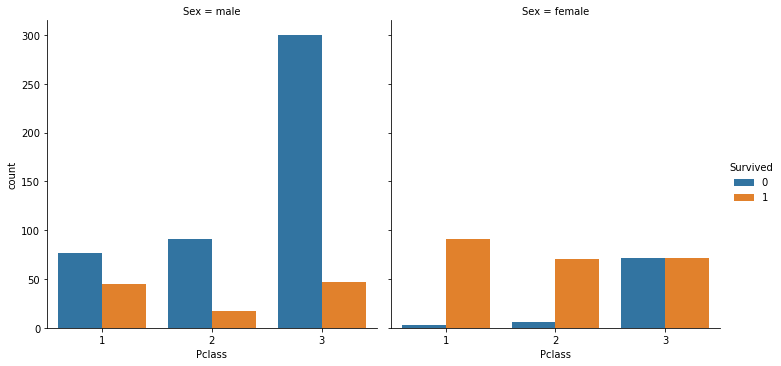

In [34]:
g=sns.catplot(data=train_data, x='Pclass', col='Sex', hue='Survived', kind='count')

#### Age

Please note there are a fraction of missing data for age, those data shall be added by some methods later

- Observations:
    1. Infant has a much higher survive possibility
    2. the oldest person(Age=80) survived which shall be removed as an outlier
    3. most passengers' age are in bewteen 15 and 40
    4. higher fraction of passengers are in Pclass 1
- Decisions:
    1. consider to bucktize the data or use it in a continuous form directly
    2. consider to remove the person who is aged at 80 for model trainning
    3. For the missing value, it has been found the age is related with the title in the name and number of relatives, a KNNimputer will be used to fill those data

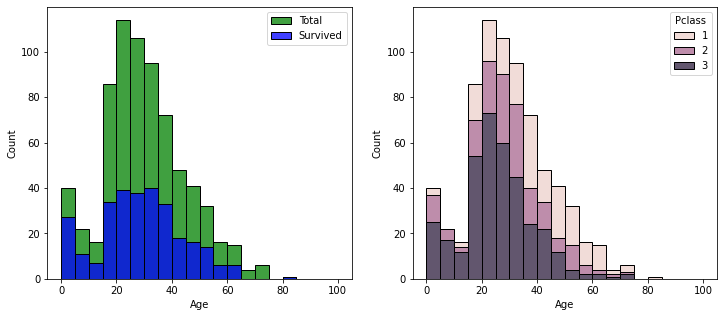

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

g1 = sns.histplot(data=train_data, x='Age', ax=ax[0], color='g', bins=20, binrange=(0, 100))
g2 = sns.histplot(data=train_data[train_data['Survived']==1]
                  , x='Age', ax=ax[0], color='b', bins=20, binrange=(0, 100))
ax[0].legend(labels=['Total', 'Survived'])

g1 = sns.histplot(data=train_data, x='Age', ax=ax[1], 
                  multiple='stack', hue='Pclass',
                  bins=20, binrange=(0, 100))

Text(0, 0.5, 'survive fraction')

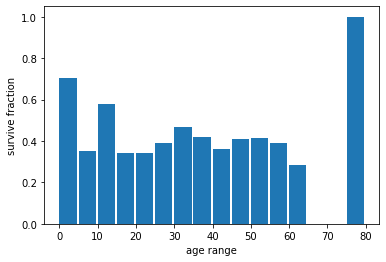

In [107]:
bins = [i for i in range(0, 85, 5)]
train_data['Age_binned'] = pd.cut(train_data['Age'], bins=bins)
fig, ax = plt.subplots(1,1)
fraction = (train_data[['Survived', 'Age_binned']]
            .groupby('Age_binned', as_index=False)
            .mean()['Survived'])
fraction
ax.bar(x=bins[:-1], height=fraction, align='edge', width=4.5)
ax.set_xlabel('age range')
ax.set_ylabel('survive fraction')

#### SibSp & Parch
Please aware that the number of relatives of person onboard could also be related with his/her age

- Observations:
    1. The relationship between SibSp&Parch with surviving possibility is not clear
- Decisions:
    1. we shell derive some new feature use it or discard it
    

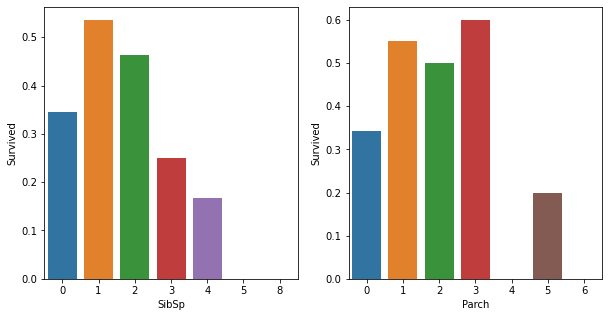

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_1 = (train_data[['SibSp', 'Survived']]
        .groupby('SibSp', as_index=False)
        .mean().sort_values(by='SibSp'))
df_2 = (train_data[['Parch', 'Survived']]
        .groupby('Parch', as_index=False)
        .mean().sort_values(by='Parch'))
ax1 = sns.barplot(data=df_1, x='SibSp', y='Survived',  ax=ax[0])
ax2 = sns.barplot(data=df_2, x='Parch', y='Survived',  ax=ax[1])


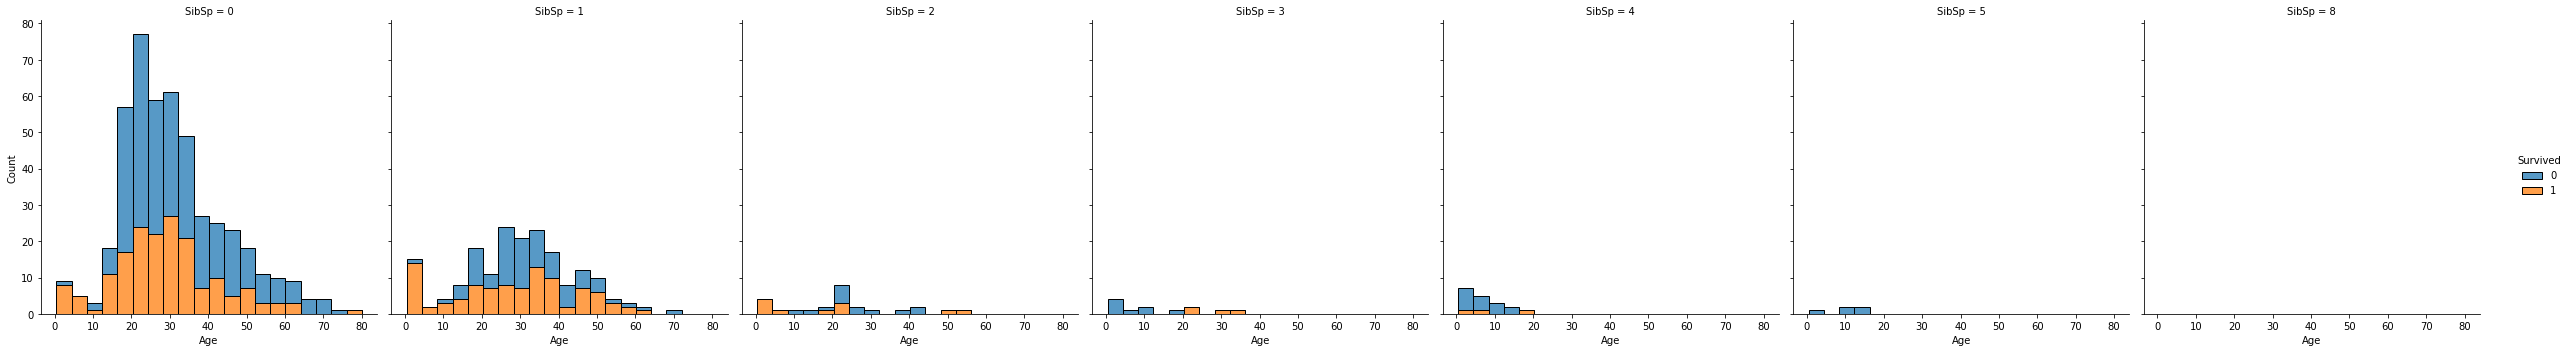

In [137]:
sns.displot(data=train_data, col='SibSp', x='Age', hue='Survived', multiple='stack')

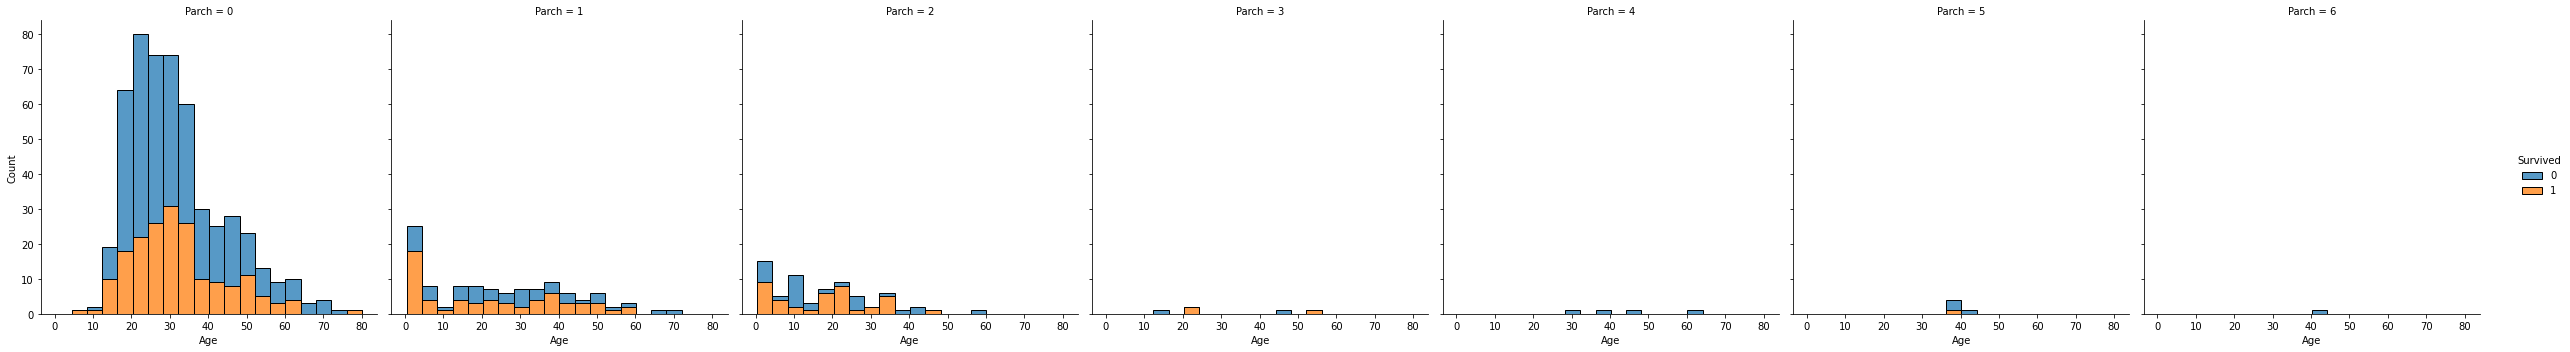

In [123]:
sns.displot(data=train_data, col='Parch', x='Age', hue='Survived', multiple='stack')

In [156]:
train_data['Cabin_cat']=train_data['Cabin'].apply(lambda x: 'None' if x is np.nan else x[0])
test_data['Cabin_cat']=test_data['Cabin'].apply(lambda x: 'None' if x is np.nan else x[0])

In [35]:
train_data[['Age', 'SibSp', 'Parch']].groupby(['SibSp', 'Parch'], as_index=False).mean()

,SibSp,Parch,Age
0,0,0,32.220297
1,0,1,29.524865
2,0,2,20.993462
3,0,3,24.000000
4,0,4,29.000000
5,0,5,40.000000
6,1,0,32.068627
7,1,1,27.064815
8,1,2,20.465882
9,1,3,39.333333


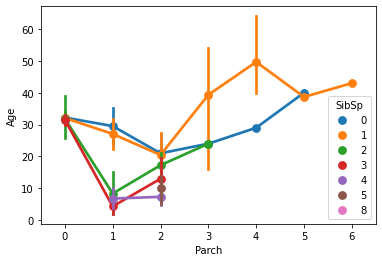

In [38]:
g = sns.pointplot(data=train_data, hue='SibSp', x='Parch', y='Age')

In [39]:
for dataset in (train_data, test_data):
    dataset['Title'] = dataset['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    dataset['Title_cat']=dataset['Title'].apply(
        lambda x: x if x in {'Mr', 'Miss', 'Mrs', 'Master'} else 'others'
    )

In [40]:
train_data['Title_cat']

0          Mr
1         Mrs
2        Miss
3         Mrs
4          Mr
        ...  
886    others
887      Miss
888      Miss
889        Mr
890        Mr
Name: Title_cat, Length: 891, dtype: object

In [27]:
train_data['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [34]:
train_data.loc[(train_data['Title']=='Countess')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,Countess


In [8]:
train_data.loc[(train_data['Sex']=='female') & (train_data['Age']<30)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,NaN,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S


#### Fare

- Observations:
    1. Passeger paid higher fare is likely to survive

- Decisions:
    2. consider to use it as continuous feature directly or binned in the model

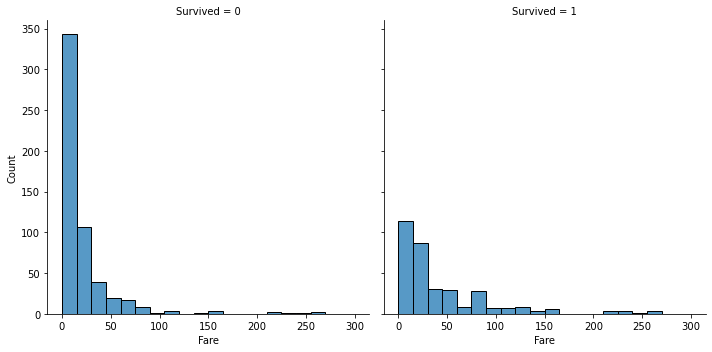

In [141]:
g = sns.displot(data=train_data, col='Survived', x='Fare', bins=20, binrange=(0, 300))

#### Embarked

- Observations:
    1. Passegers embarked at S has a lower survive possibility for all three Pclass

- Decisions:



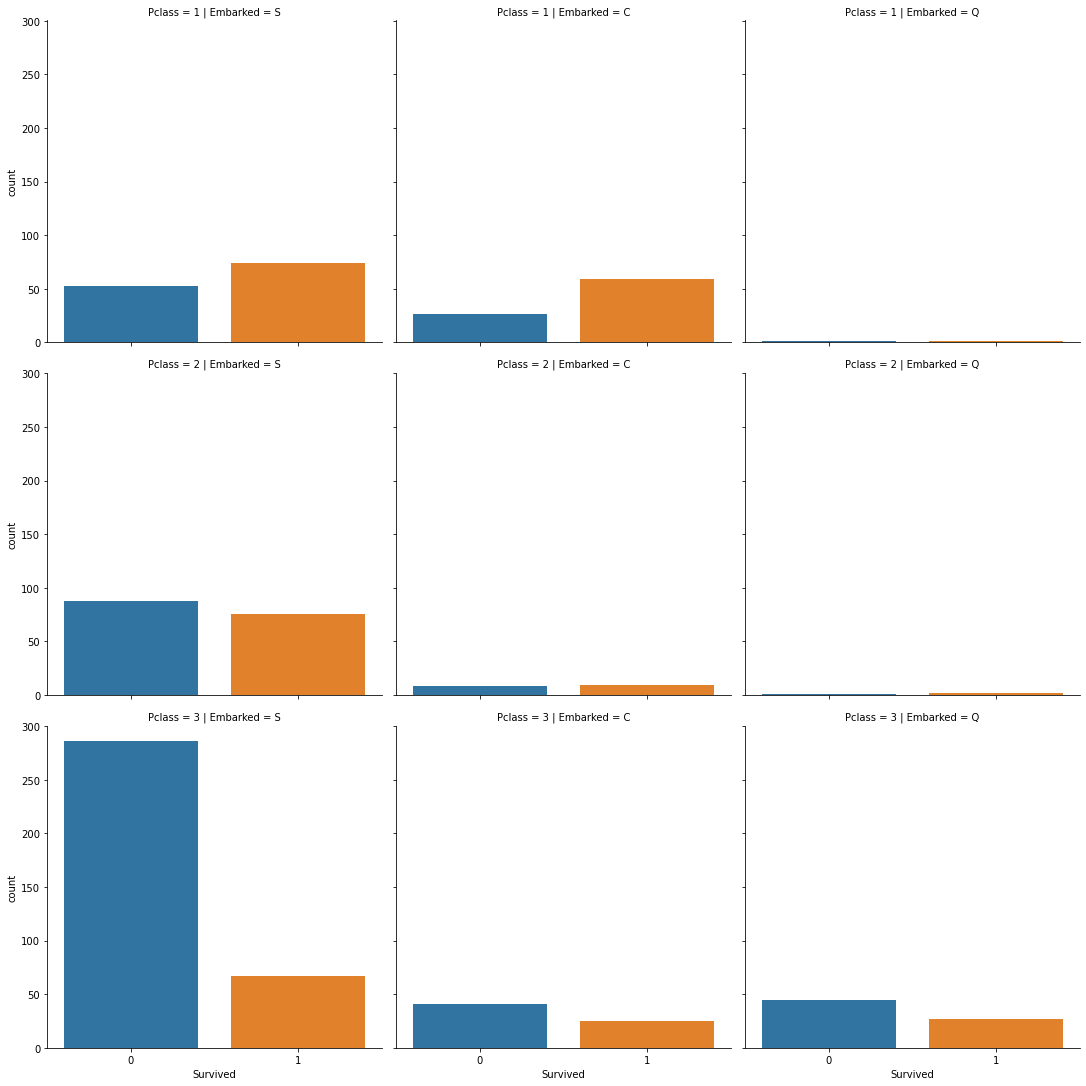

In [155]:
g=sns.catplot(data=train_data, col='Embarked', row='Pclass', x='Survived', kind='count')

In [63]:
corr = train_data[category_encoded_cols].corr(method=theils_u)
corr

,Survived_encoded,Pclass_encoded,Sex_encoded,Cabin_cat_encoded,Embarked_encoded
Survived_encoded,1.000000,0.087260,0.226562,0.082776,0.025031
Pclass_encoded,0.087260,1.000000,0.009525,0.363801,0.074002
Sex_encoded,0.226562,0.009525,1.000000,0.034199,0.014929
Cabin_cat_encoded,0.082776,0.363801,0.034199,1.000000,0.051315
Embarked_encoded,0.025031,0.074002,0.014929,0.051315,1.000000


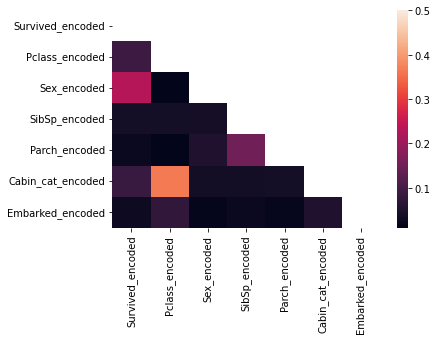

In [22]:
corr = train_data[category_encoded_cols].corr(method=theils_u)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(corr, mask=mask, vmax=0.5)

In [30]:
corr = train_data[numerical_cols].corr()
corr

,Survived,Age,Fare,SibSp,Parch
Survived,1.000000,-0.077221,0.257307,-0.035322,0.081629
Age,-0.077221,1.000000,0.096067,-0.308247,-0.189119
Fare,0.257307,0.096067,1.000000,0.159651,0.216225
SibSp,-0.035322,-0.308247,0.159651,1.000000,0.414838
Parch,0.081629,-0.189119,0.216225,0.414838,1.000000


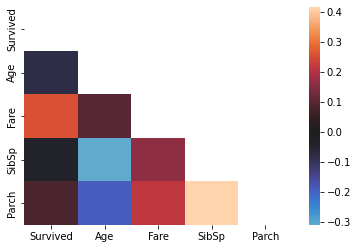

In [48]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(corr, mask=mask, center=0)

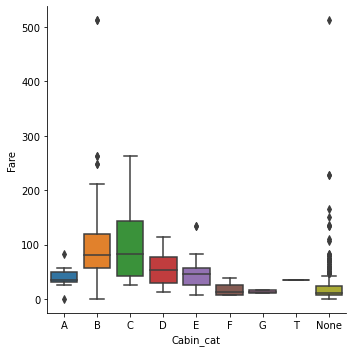

In [45]:
g = sns.catplot(data=train_data, x='Cabin_cat', y='Fare', kind='box',
                order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'None'])

In [51]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

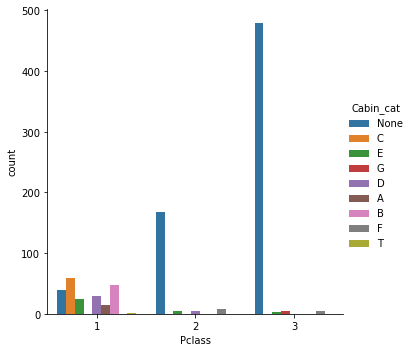

In [54]:
g = sns.catplot(data=train_data, x='Pclass', hue='Cabin_cat', kind='count')

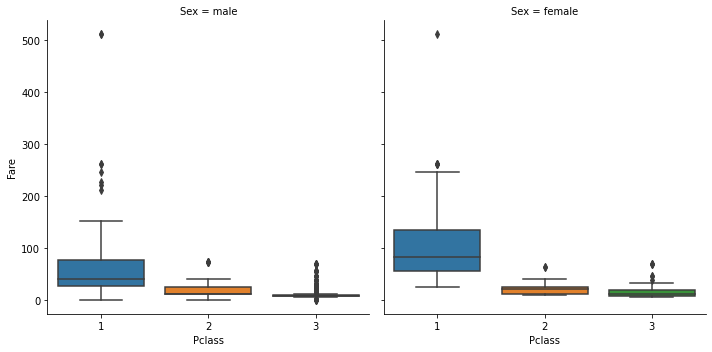

In [61]:
g = sns.catplot(data=train_data, x='Pclass', y='Fare', kind='box', col='Sex')